### Importing all required libraries


In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchinfo
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import sklearn
import random
import warnings
from tqdm import tqdm
from IPython.display import clear_output # for clearing output in jupyter notebook
from sklearn.metrics import precision_score, recall_score # we will use these to keep track of model performance during training, more on this later


warnings.filterwarnings("ignore")

# enable CUDNN profiling (faster runtime)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 500
FL_GAMMA = 2.0 # gamma parameter for focal loss
PATIENCE = 20 # patience for early stopping
WARMUP_EPOCHS = 10 # number of epochs for warmup
LR_PATIENCE = 5 # patience for learning rate scheduler

### Helper function to get dataset files

In [3]:
def get_list_of_files(data_path: str=r'./splits') -> list[tuple[str, str]]:
    file_paths = []
    data_folders = ["test", "train", "val"]
    
    for each in data_folders:
        # ../splits/[test/train/val]/input
        input_folder = os.path.join(data_path, each, 'input')
        # ../splits/[test/train/val]/target 
        target_folder = os.path.join(data_path, each, 'target')
    
        # check to make sure folders exist
        if not os.path.isdir(input_folder): raise FileNotFoundError(f'Input folder {input_folder} not found')
        if not os.path.isdir(target_folder): raise FileNotFoundError(f'Target folder {target_folder} not found')
        
        # grab tifs
        input_tifs = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
        
        for input_tif in input_tifs:
            # try to look for corresponding tifs in target dir
            target_tif = os.path.join(target_folder, input_tif)
            if os.path.isfile(target_tif):
                file_paths.append((os.path.join(input_folder, input_tif), target_tif)) # add input_tif's and matching target tif's loc
            
    return file_paths

file_paths = get_list_of_files(r'/home/kevin/Aayam/U-NET/splits')
print(f'Found \033[35m{len(file_paths)}\033[0m files!')

Found 250 files!


### Demo of rasterio

In [4]:
src_file = file_paths[0][0]
with rio.open(src_file) as src:
    meta = src.meta # grab geo metadata
    data = src.read() # grab raster data as numpy array
    red_band = src.read(1) # only grab red band as numpy array

print(f"""\033[35mRaster metadata:\033[0m {meta}
\033[35mRaster shape:\033[0m {data.shape}
\033[35mRed band raster shape:\033[0m {red_band.shape}""")

Raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 256, 'height': 256, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",32.5],PARAMETER["central_meridian",-89.75],PARAMETER["scale_factor",0.9998335],PARAMETER["false_easting",500000],PARAMETER["false_northing",1300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 531037.9870497471,
       0.0, -1.0, 1069981.8776918147)}
Raster shape: (3, 256, 256)
Red band raster shape: (256, 256)


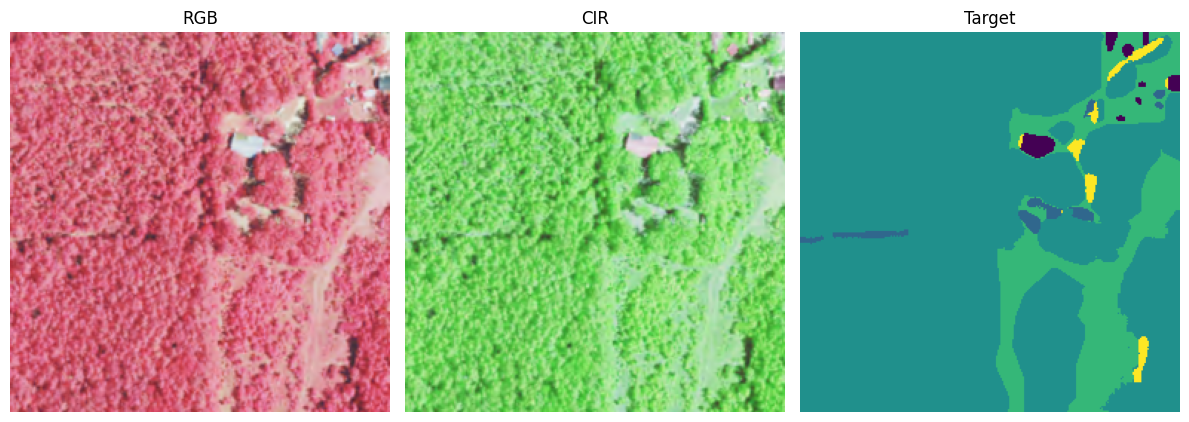

In [5]:
data_rgb = data[:3] # create RGB image of src_file
data_cir = data[[2, 0, 1], :, :] # grab only the GR NIR bands


# grab the corresponding target file for the src_file
target_file = file_paths[0][1]
with rio.open(target_file) as src:
    target_meta = src.meta # grab geo metadata
    target = src.read() # grab raster data as numpy array


img_files = [data_rgb, data_cir, target]
img_titles = ["RGB", "CIR", "Target"]

f, ax = plt.subplots(1, 3, figsize=(12, 5))
for idx, (img, title) in enumerate(zip(img_files, img_titles)):
    ax[idx].imshow(img.transpose(1, 2, 0)) # transpose to reorder the dimensions
    ax[idx].set_title(title)
    ax[idx].axis('off')
plt.tight_layout()

### Basic helper function

In [6]:
def print_array_info(array):
    print('\033[35mArray shape:\033[0m', array.shape)
    print('\033[35mArray dtype:\033[0m', array.dtype)
    print('\033[35mArray range:\033[0m', array.min(), array.max())
    
print_array_info(data)
print_array_info(target)

Array shape: (3, 256, 256)
Array dtype: uint8
Array range: 32 248
Array shape: (1, 256, 256)
Array dtype: uint8
Array range: 2 8


### Functionalizing the viz code

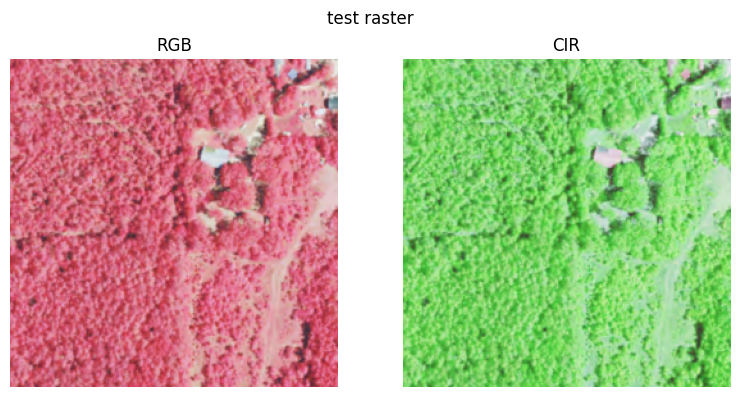

In [7]:
def visualize_raster(raster, title=None):

    rgb = raster[:3] # create RGB image
    cir = raster[[2, 0, 1], :, :] # grab only the G R NIR bands

    rgb = rgb.transpose(1, 2, 0)
    cir = cir.transpose(1, 2, 0)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    img_data = [rgb, cir]; img_title = ["RGB", "CIR"]
    for idx, (img, ttl) in enumerate(zip(img_data, img_title)):
        ax[idx].imshow(img, vmin=0, vmax=255)
        ax[idx].set_title(ttl)
        ax[idx].axis('off')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

visualize_raster(data, 'test raster')

### Image data labels & target viz

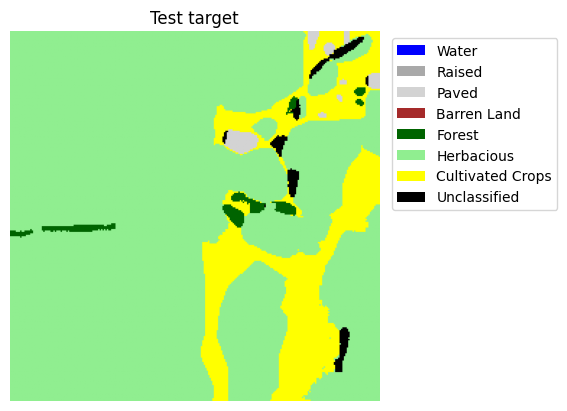

In [8]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

land_cover_colors = [
    'blue',        # 1 - Water
    'darkgray',    # 2 - Raised structures
    'lightgray',   # 3 - Paved surfaces
    'brown',       # 4 - Barren Land
    'darkgreen',   # 5 - Forest
    'lightgreen',  # 6 - Herbacious
    'yellow',      # 7 - Cultivated Crops
    'black',       # 8 - Unclassified    
]

land_cover_labels = [
    'Water',
    'Raised',
    'Paved',
    'Barren Land',
    'Forest',
    'Herbacious',
    'Cultivated Crops',
    'Unclassified',
]

land_cover_cmap = ListedColormap(land_cover_colors, name='land-cover') # create color map object
land_cover_legend=[Patch(label = label, facecolor=color) for label, color in zip(land_cover_labels, land_cover_colors)]

# Make function similar to visualize_raster
def visualize_target(target, title=None):
    if target.ndim == 3:
        target = target.squeeze(0) # remove extra dimension if necessary

    plt.imshow(target, cmap=land_cover_cmap, vmin=0, vmax=8)
    plt.axis('off')
    plt.legend(handles=land_cover_legend, loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.title(title)
    plt.show()

visualize_target(target, 'Test target')

### Display plot class distribution

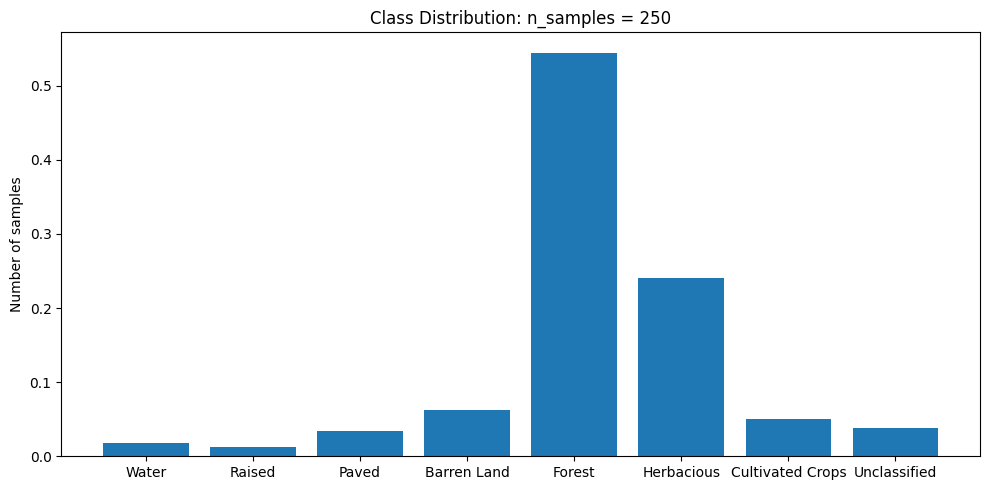

In [9]:
def plot_class_distribution(y):
    class_dist = np.unique(y, return_counts=True)[1] # get counts of each class
    class_dist = class_dist / class_dist.sum() # standardize to sum to 1

    plt.figure(figsize=(10, 5)) 
    plt.bar(range(len(class_dist)), class_dist)
    plt.xticks(ticks=range(len(class_dist)), labels=land_cover_labels)
    plt.ylabel('Number of samples')
    plt.title(f'Class Distribution: n_samples = {len(y)}')
    plt.tight_layout()
    plt.show()

    return class_dist
    
y = np.array([rio.open(target_file).read() for _, target_file in file_paths])
y = y -1 # subtract 1 from all values to make the range 0-7 instead of 1-8
y_class_dist = plot_class_distribution(y)

### Splitting the dataset

In [10]:
random.seed(1701) # set random seed for reproducibility

n_total_samples = len(file_paths)
n_test_samples = int(n_total_samples * 0.2) # 20% of data will be used for testing
n_val_samples = int(n_total_samples * 0.2) # 20% of data will be used for validation
n_train_samples = n_total_samples - n_test_samples - n_val_samples # the rest of the data will be used for training

print(f"""\033[35mTotal samples:\033[0m {n_total_samples}
\033[35mTraining samples:\033[0m {n_train_samples}
\033[35mTest samples:\033[0m {n_test_samples}
\033[35mValidation samples:\033[0m {n_val_samples}""")

# shuffle the file paths (in-place operation)
random.shuffle(file_paths)

# split file paths into train, test, and validation sets
train_file_paths = file_paths[:n_train_samples]
val_file_paths = file_paths[n_train_samples:n_train_samples+n_val_samples]
test_file_paths = file_paths[n_train_samples+n_val_samples:]

Total samples: 250
Training samples: 150
Test samples: 50
Validation samples: 50


### Custom dataset class

In [11]:
from torch.utils.data import Dataset

# our custom GCER_Dataset class will inherit from the Dataset class
class GCER_Dataset(Dataset):
    
    def __init__(self, files: list[tuple[str, str]], transform=None):
        self.file_path_list = files
        self.transform = transform # more on this later
        self.class_dist = None # we will use this later
        
        # min and max values of the imagery (per bands)
        X = np.array([rio.open(file[0]).read() for file in self.file_path_list])
        self.mins = X.min(axis=(0, 2, 3), keepdims=True).squeeze(0)
        self.maxs = X.max(axis=(0, 2, 3), keepdims=True).squeeze(0)
        self.range = self.maxs - self.mins
        
    def __len__(self):
        return len(self.file_path_list)
    
    # __getitem__() is called when indexed in the form dataset[i]
    # typically a __getitem__() method returns a single sample from the dataset
    # in the form of a tuple: (X, y) where X is the data fed into
    # the model and y is the ground truch label associated with the data.
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, dict]:
        
        file_path = self.file_path_list[index] # get file path to laod
        
        # load raster data to memory
        X = rio.open(file_path[0]).read()
        y = rio.open(file_path[1]).read()
        
        # convert to torch tensors
        X = torch.from_numpy(X).type(torch.FloatTensor) # convert to float tensor
        y = torch.from_numpy(y).type(torch.FloatTensor) # convert to float tensor
        
        # standardize input data
        X = np.subtract(X, self.mins) # subtract min
        X = np.divide(X, self.range) # divide by range
        
        # subtract 1 from labels so that classes are indexed from 0 to 6 (instead of 1 to 7)
        y = y - 1
        
        # image transformations (more on this later)
        if self.transform:
            X, y = self.transform(X, y)
        
        return X, y
    
    # NOTE: we can add additional methods to our custom dataset class to make our
    # lives easier. For example, let's create a method that returns the class distribution
    # of the dataset
    
    def get_class_distribution(self, density: bool=True) -> np.array:
        
        if self.class_dist is not None: return self.class_dist # return cached result if available
        
        # load all labels into memory (as numpy array)
        labels = np.array([rio.open(file_path[1]).read() for file_path in self.file_path_list])
        
        # subtract 1 from labels so that classes are indexed from 0 to 6 (instead of 1 to 7)
        labels = labels - 1
        
        # get class distribution using numpy histogram function
        self.class_dist = np.histogram(labels, bins=8, density=density, range=(0, 8))[0]
        
        return self.class_dist

    def plot_class_distribution(self) -> np.array:
        
        class_dist = self.get_class_distribution()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.bar(range(len(class_dist)), class_dist)
        ax.set_xticks(range(len(class_dist)))
        ax.set_xticklabels(land_cover_labels)
        
        ax.set_ylabel('Number of Samples')
        ax.set_title(f'Class Distribution: n_samples = {self.__len__()}')
        fig.tight_layout()
        plt.show()
        
        return class_dist

### Testing the above function

Array shape: torch.Size([3, 256, 256])
Array dtype: torch.float32
Array range: tensor(0.0135) tensor(0.9722)
Array shape: torch.Size([1, 256, 256])
Array dtype: torch.float32
Array range: tensor(1.) tensor(7.)


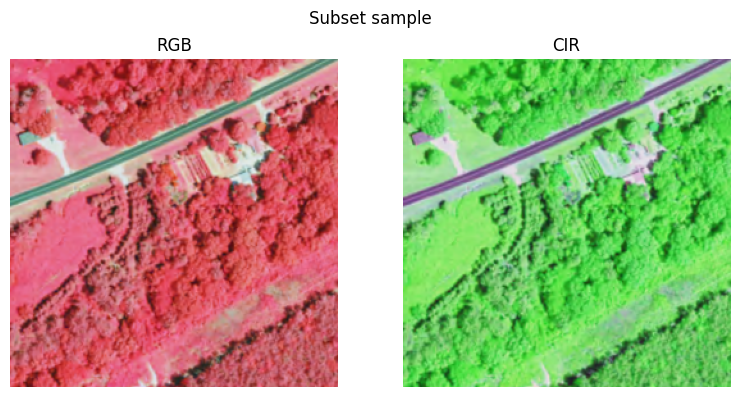

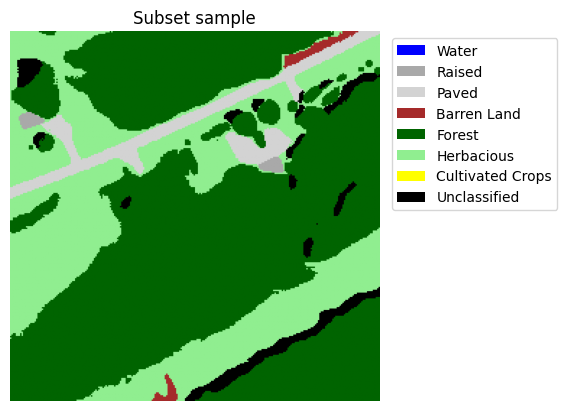

Number of samples in dataset: 5


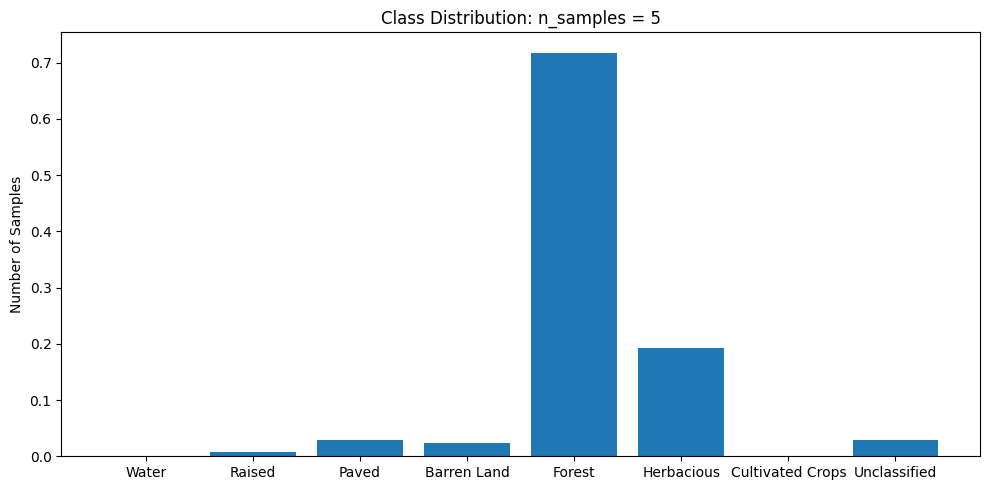

array([0.00098267, 0.00731812, 0.02818298, 0.02441711, 0.71781311,
       0.19236755, 0.        , 0.02891846])

In [12]:
subset_files = file_paths[:5] # select first 5 samples of full dataset for subset
subset_dataset = GCER_Dataset(subset_files) # create dataset object

# since the __getitem__ method has been overridden, we can access samples in the 
# dataset using the indexing operator [], similar to how we would index a list
X_temp, y_temp = subset_dataset[0] # get first sample in dataset
print_array_info(X_temp) # NOTE: because X and y are torch tensors, the output will vary sligtly from previous examples
print_array_info(y_temp)

visualize_raster(X_temp.numpy(), 'Subset sample')
visualize_target(y_temp.numpy(), 'Subset sample')

# check how many samples are in the dataset
print(f'\033[35mNumber of samples in dataset:\033[0m {len(subset_dataset)}') # __len__ method has been overriden

# check class distribution
subset_dataset.plot_class_distribution()

### Data augmentation

Array shape: torch.Size([3, 256, 256])
Array dtype: torch.float32
Array range: tensor(0.0135) tensor(0.9722)
Array shape: torch.Size([1, 256, 256])
Array dtype: torch.float32
Array range: tensor(1.) tensor(7.)


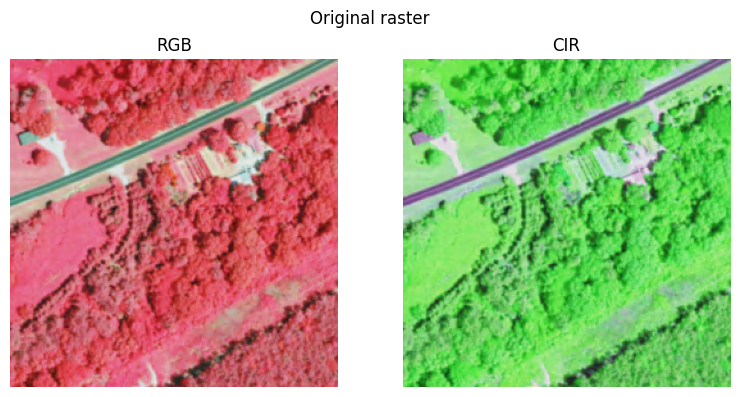

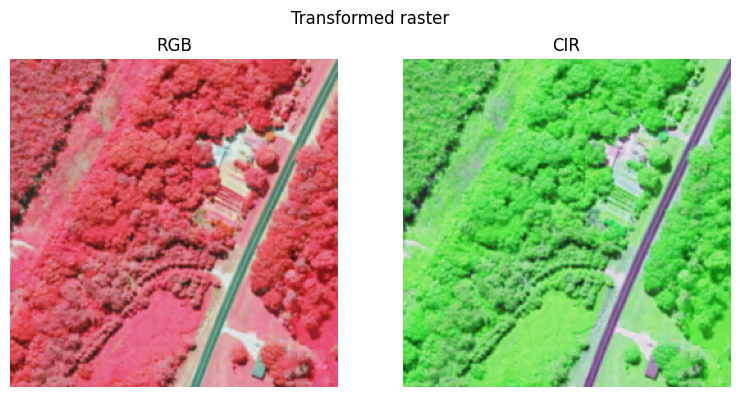

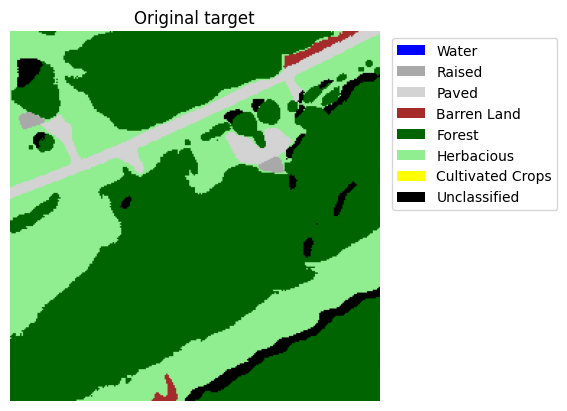

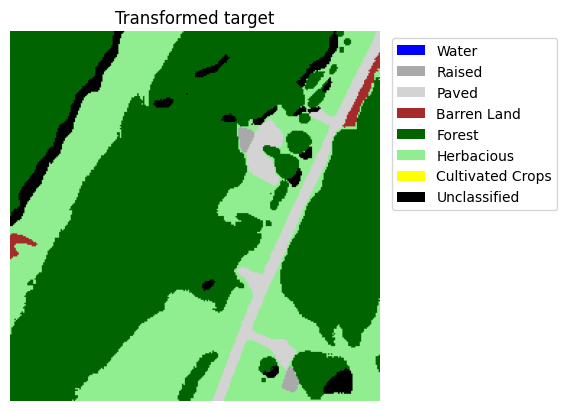

In [13]:
from torchvision.transforms.functional import rotate, hflip, vflip

class RotateAndFlipTransforms:
    
    def __init__(self) -> None:
        self.angles = [90, 180, 270] # possible angles to rotate (0 and 360 are the same as the original)
        self.p_rotate = 0.75 # probability of rotating
        self.p_flip = 0.5 # probability of flipping
    
    def __call__(self, X: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        # rotate with probability p_rotate
        if random.random() < self.p_rotate: 
            angle = random.choice(self.angles) # if rotating, choose a random angle
            X = rotate(X, angle)
            y = rotate(y, angle)

        # horizontal flip with probability p_flip
        if random.random() < self.p_flip: # horizontal flip with probability p_flip
            X = hflip(X)
            y = hflip(y)
            
        # vertical flip with probability p_flip
        if random.random() < self.p_flip:
            X = vflip(X)
            y = vflip(y)
        
        return X, y

transform = RotateAndFlipTransforms()

# testing the transform
X_temp_aug, y_temp_aug = transform(X_temp, y_temp)

# print array info
print_array_info(X_temp_aug)
print_array_info(y_temp_aug)

# visualize transformed data
# NOTE: should convert torch tensors to numpy arrays before visualizing
visualize_raster(X_temp.numpy(), title='Original raster')
visualize_raster(X_temp_aug.numpy(), title='Transformed raster')
visualize_target(y_temp.numpy(), title='Original target')
visualize_target(y_temp_aug.numpy(), title='Transformed target')

In [14]:
train_dataset = GCER_Dataset(train_file_paths, transform=RotateAndFlipTransforms()) 
train_class_dist = train_dataset.get_class_distribution()
print('\033[35mClass distribution for training set:\033[0m', train_class_dist)

val_dataset = GCER_Dataset(val_file_paths) # no need for transforms on validation/test sets
val_class_dist = val_dataset.get_class_distribution()
print('\033[35mClass distribution for validation set:\033[0m', val_class_dist)

test_dataset = GCER_Dataset(test_file_paths)
test_class_dist = test_dataset.get_class_distribution()
print('\033[35mClass distribution for test set:\033[0m', test_class_dist)

Class distribution for training set: [0.02213369 0.01284434 0.03324656 0.07361115 0.54104279 0.2249054
 0.05525441 0.03696167]
Class distribution for validation set: [0.0113324  0.01107391 0.03260437 0.05186096 0.5179834  0.2840564
 0.05183411 0.03925446]
Class distribution for test set: [0.01130188 0.01175201 0.04036072 0.03718933 0.58327972 0.24392639
 0.03065918 0.04153076]


## U-Net model

In [15]:
# code is modified from https://github.com/milesial/Pytorch-UNet
# in order to comply with GPLv3, link to original code is provided above and 
# GPL v3 license is included in the repository

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels): # remove bilinear option
        super(Up, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2], mode='reflect')
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding_mode='reflect')

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, channels=[64, 128, 256, 512, 1024]):
        super(UNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channels = channels
        
        # need to use nn.ModuleList since encoder and decoder are lists of nn.Modules
        self.encoder = nn.ModuleList([(DoubleConv(n_channels, channels[0]))])
        for i in range(len(channels) - 1): 
            self.encoder.append(Down(channels[i], channels[i+1]))
            
        self.decoder = nn.ModuleList([])
        for i in range(len(channels) - 1, 0, -1):
            self.decoder.append(Up(channels[i], channels[i-1]))
        
        self.outc = (OutConv(channels[0], n_classes))

    def forward(self, x):
        
        encoder_layer_outputs = [] # need to store outputs from each layer in the encoder
        for layer in self.encoder:
            x = layer(x)
            if len(encoder_layer_outputs) < len(self.encoder) - 1: # don't save output from last encoder layer
                encoder_layer_outputs.append(x)
        
        # pass output from each encoder layer to corresponding decoder layer
        for layer in self.decoder:
            x = layer(x, encoder_layer_outputs.pop()) # pass output from corresponding encoder layer
        
        # final convolutional layer
        return self.outc(x)

### Initializing the model

In [16]:
model = UNet(n_channels=3, n_classes=8) # create model

test_x = torch.randn(1, 3, 256, 256) # create a random input sample (dummy)
test_y = model(test_x) # feed the input sample to the model

print('\033[35mOutput shape:\033[0m', test_y.shape) # print the output shape

Output shape: torch.Size([1, 8, 256, 256])


### Loss function

Loss:  1.4208569526672363


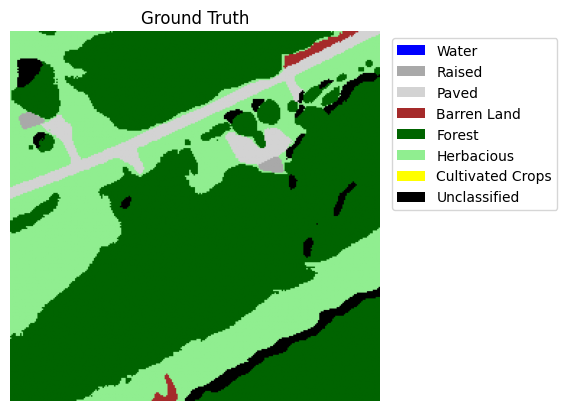

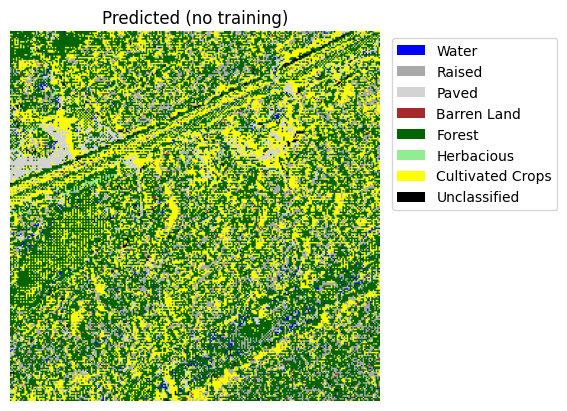

In [17]:
# basic focal loss implementation from 
# https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py

class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self, alpha=None, gamma=2., ignore_index=-100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 2.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """

        super().__init__()
        if alpha is not None:
            if not isinstance(alpha, torch.Tensor):
                alpha = torch.tensor(alpha)
            alpha = alpha.float()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x, y):
        
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0: return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        # print(x.dtype)
        log_p = F.log_softmax(x, dim=-1)
        y = y.long() # https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type-float-when-using-crossentropyloss/30542/2
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce
        loss = loss.mean() # only using mean reduction for simplicity

        return loss

# quick test of focal loss
X_loss_test, y_loss_test = subset_dataset[0] # get first sample in dataset


# need to add batch dimension to input and target
X_loss_test = X_loss_test.unsqueeze(0)
y_loss_test = y_loss_test.unsqueeze(0)

test_loss_fn = FocalLoss() # create loss function object

y_hat_loss_test = model(X_loss_test) # run inference
test_loss = test_loss_fn(y_hat_loss_test, y_loss_test) # calculate loss

print('\033[35mLoss: \033[0m', test_loss.item())

# Visualize inferred image. Will look bad at first, that's okay
y_raster = y_hat_loss_test.squeeze().detach() # convert target to numpy array
y_raster = y_raster.numpy()
y_raster = y_raster.argmax(axis=0)

visualize_target(y_loss_test.squeeze().numpy(), title='Ground Truth')
visualize_target(y_raster, title='Predicted (no training)')

In [18]:
print("\033[35mInput shape to model:\033[0m", X_loss_test.shape)
print("\033[35mModel input channels expected:\033[0m", model.n_channels if hasattr(model, 'n_channels') else 'Unknown')

Input shape to model: torch.Size([1, 3, 256, 256])
Model input channels expected: 3


In [19]:
alpha = (1 - train_class_dist)**2 # increase exponent to increase weight of underrepresented classes
# make alpha mean = 1
alpha = alpha / alpha.mean()
print(alpha)

[1.20375944 1.22673856 1.17655487 1.08035722 0.26517046 0.75629314
 1.12359676 1.16752955]


### Optimizer and loss function setup

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = FocalLoss(gamma=FL_GAMMA, alpha=alpha)
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda x: 0.1*x if x < WARMUP_EPOCHS else 1, # lr reduced by a factor of 100 for first few epochs
    # verbose=True,
)
reduce_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE)

In [21]:
model = model.to(device) # move model to GPU
loss_fn = loss_fn.to(device) # move loss function to GPU

# visualize model architecture + number of trainable parameters
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [16, 8, 256, 256]         --
├─ModuleList: 1-1                                  --                        --
│    └─DoubleConv: 2-1                             [16, 64, 256, 256]        --
│    │    └─Sequential: 3-1                        [16, 64, 256, 256]        38,848
│    └─Down: 2-2                                   [16, 128, 128, 128]       --
│    │    └─Sequential: 3-2                        [16, 128, 128, 128]       221,696
│    └─Down: 2-3                                   [16, 256, 64, 64]         --
│    │    └─Sequential: 3-3                        [16, 256, 64, 64]         885,760
│    └─Down: 2-4                                   [16, 512, 32, 32]         --
│    │    └─Sequential: 3-4                        [16, 512, 32, 32]         3,540,992
│    └─Down: 2-5                                   [16, 1024, 16, 16]        --
│    │    └─Se

### Defining datasets

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)

### Model training

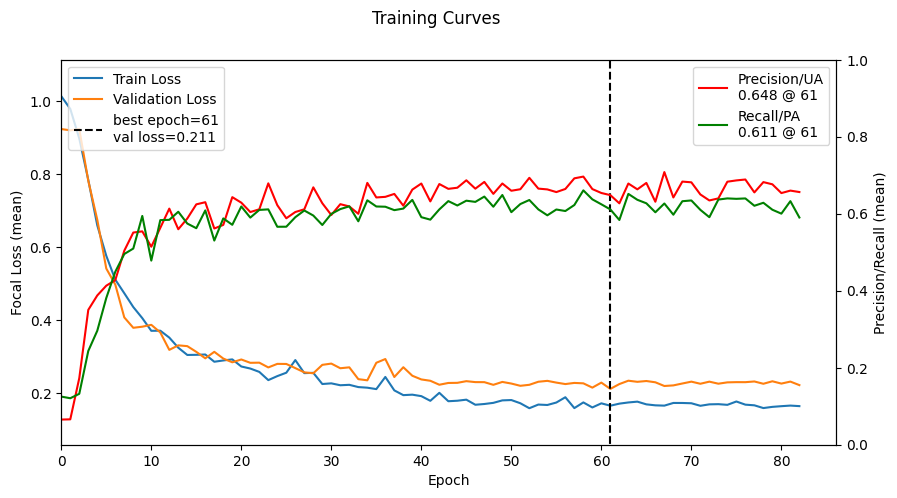

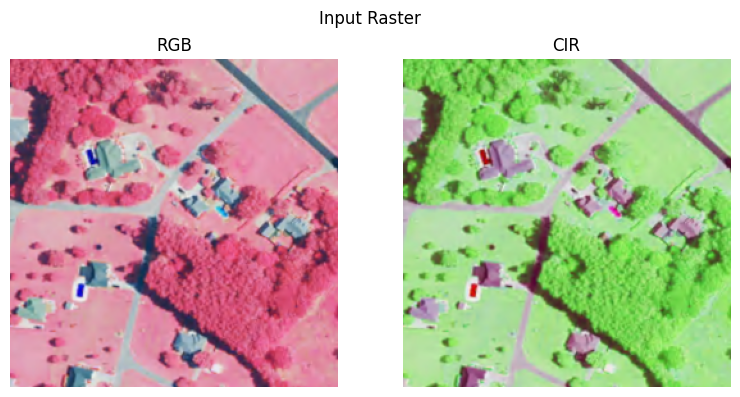

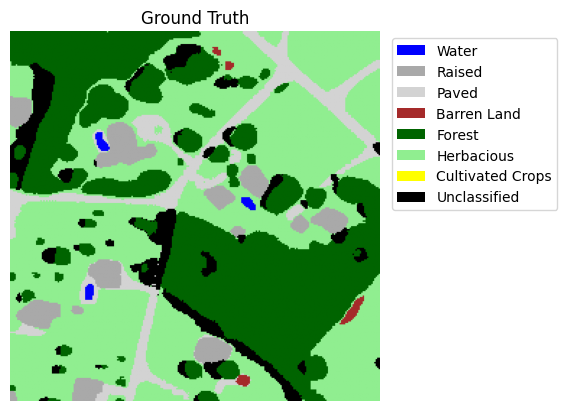

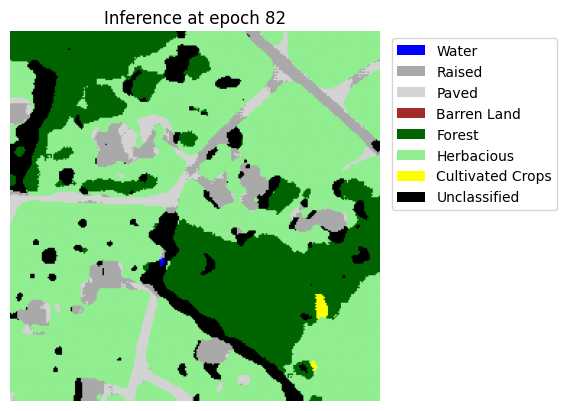

Validation loss has not improved for 20 epochs. Stopping early at epoch 82


In [23]:
# save loss values for plotting
train_losses = []
val_losses = []
precision_scores = []
recall_scores = []

# only want to save the model with the best validation loss
best_epoch = 0
best_val_loss = float('inf') # set best validation loss to infinity to start

for epoch in range(NUM_EPOCHS):

    # train step
    epoch_train_loss = 0.0
    model.train() # set model to train mode (enables autograd and dropout)
    train_batch_losses = []

    with tqdm(train_loader, unit="batch", desc=f'Epoch {epoch}/{NUM_EPOCHS} train step') as t_train: # create a progress bar for training
        for X, y in t_train:
            optimizer.zero_grad(set_to_none=True) # reset gradients to 0 (PyTorch does not do this automatically
            # move data to GPU if available
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            train_batch_losses.append(loss.item())
            running_train_loss = sum(train_batch_losses) / len(train_batch_losses)
            epoch_train_loss += (loss.item() * len(X)) # add total batch loss to epoch loss
            t_train.set_postfix(loss=running_train_loss)
            
            loss.backward() # backpropagate loss
            optimizer.step() # update optimizer parameters (lr, momentum, etc.)
    
    train_losses.append(running_train_loss) # calculate average loss for epoch and append to list
    
    # validation step
    model.eval() # set model to eval mode (disables autograd and dropout)
    val_batch_losses = []
    running_precision_scores = []
    running_recall_scores = []
    
    with tqdm(val_loader, unit="batch", desc=f'Epoch {epoch}/{NUM_EPOCHS} val step') as t_val: # create a progress bar for validation
        for X, y in t_val:
            # move data to GPU if available
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            val_batch_losses.append(loss.item())
            running_val_loss = sum(val_batch_losses) / len(val_batch_losses)
            t_val.set_postfix(val_loss=running_val_loss)
            
            # convert y and y_hat from torch tensors to numpy arrays and flatten
            y_cpu = y.cpu().numpy().flatten()
            y_hat_cpu = y_hat.argmax(axis=1).cpu().numpy().flatten() # argmax to convert from class confidence to class index
            
            running_recall_scores.append(recall_score(y_cpu, y_hat_cpu, average='macro'))
            running_precision_scores.append(precision_score(y_cpu, y_hat_cpu, average='macro'))
    
    val_losses.append(running_val_loss) # calculate average loss for epoch and append to list
    
    recall_scores.append(sum(running_recall_scores) / len(running_recall_scores))
    precision_scores.append(sum(running_precision_scores) / len(running_precision_scores))
    
    # update best validation loss and save model if new best is found
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), './best_model.pth')
        
    # plot training curves
    clear_output(wait=True) # clear output before plotting
    
    fig, ax1 = plt.subplots(figsize=(10, 5)) # create figure. will contain loss/accuracy curves
    
    # loss curve (ax1 - left y axis)
    fig.suptitle('Training Curves')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim(left=0)
    ax1.set_ylabel('Focal Loss (mean)')

    # determine left y axis range from min/max loss values
    y_ax1_min = min(min(train_losses), min(val_losses)) # find lowest loss value across both curves
    y_ax1_min = max(0, y_ax1_min - 0.1) # add some padding to the bottom of the plot. lower bound can't be less than 0

    y_ax1_max = max(max(train_losses), max(val_losses)) + 0.1# find highest loss value across both curves, add some padding to the top of the plot

    # set y axis limits
    ax1.set_ylim(y_ax1_min, y_ax1_max)

    # add veritcal line for best epoch
    ax1.vlines(best_epoch, ymin=0, ymax=y_ax1_max, label=f'best epoch={best_epoch}\nval loss={best_val_loss:.3f}', linestyles='dashed', colors='black')

    # add legend
    ax1.legend(loc='upper left') # put next to upper left corner of plot

    # create right y axis for precision/recall curves
    ax2 = ax1.twinx()

    # plot precision/recall curves
    ax2.plot(precision_scores, label=f'Precision/UA\n{precision_scores[best_epoch]:.3f} @ {best_epoch}', color='red')
    ax2.plot(recall_scores, label=f'Recall/PA\n{recall_scores[best_epoch]:.3f} @ {best_epoch}', color='green')
    ax2.set_ylabel('Precision/Recall (mean)')
    ax2.set_ylim(0, 1) # set y axis limits to 0-1
    plt.legend(loc='upper right') # put legend in upper right corner of plot
    plt.show() # show plot
    
    # show example prediction
    y_hat_plot = y_hat[0].detach().cpu().numpy() # convert target to numpy array\
    y_hat_plot = y_hat_plot.argmax(axis=0)
    visualize_raster(X[0].cpu().numpy(), title='Input Raster')
    visualize_target(y[0].cpu().numpy(), title='Ground Truth')
    visualize_target(y_hat_plot, title=f'Inference at epoch {epoch}')
    
    # early stopping
    if epoch - best_epoch > PATIENCE:
        print(f'Validation loss has not improved for {PATIENCE} epochs. Stopping early at epoch {epoch}')
        break
    
    # finally, update schedulers
    if epoch < WARMUP_EPOCHS: # if still in warmup phase
        warmup_scheduler.step() 
    else:
        reduce_lr_scheduler.step(val_losses[-1])

### Training results

In [24]:
from sklearn.metrics import classification_report

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)
ys = np.array([])
y_hats = np.array([])

# load the best model
model.load_state_dict(torch.load('best_model.pth'))

# look at class distribution of test set
test_class_dist = test_dataset.get_class_distribution()
print(test_class_dist)

# find nuber of samples in each class
test_class_samples = np.round(test_class_dist * len(test_dataset) * (224**2)).astype(int)
print(test_class_samples)

for X, y in tqdm(test_loader, unit="batch", desc='Test step'):
    # move data to GPU if available
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    y_hat = y_hat.argmax(axis=1) # convert from one-hot to class index
    
    # cppend batch results to numpy arrays
    ys = np.append(ys, y.detach().cpu().numpy().flatten())
    y_hats = np.append(y_hats, y_hat.detach().cpu().numpy().flatten())

cr = classification_report(ys, y_hats, labels=range(0,7), target_names=land_cover_labels)
print(cr)

[0.01130188 0.01175201 0.04036072 0.03718933 0.58327972 0.24392639
 0.03065918 0.04153076]
[  28354   29483  101257   93301 1463332  611963   76918  104192]


Test step: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46batch/s]


                  precision    recall  f1-score   support

           Water       0.76      0.90      0.82     37034
          Raised       0.61      0.51      0.55     38509
           Paved       0.71      0.67      0.69    132254
     Barren Land       0.33      0.26      0.29    121862
          Forest       0.94      0.94      0.94   1911291
      Herbacious       0.71      0.75      0.73    799298
Cultivated Crops       0.03      0.02      0.02    100464

       micro avg       0.82      0.81      0.82   3140712
       macro avg       0.58      0.58      0.58   3140712
    weighted avg       0.81      0.81      0.81   3140712



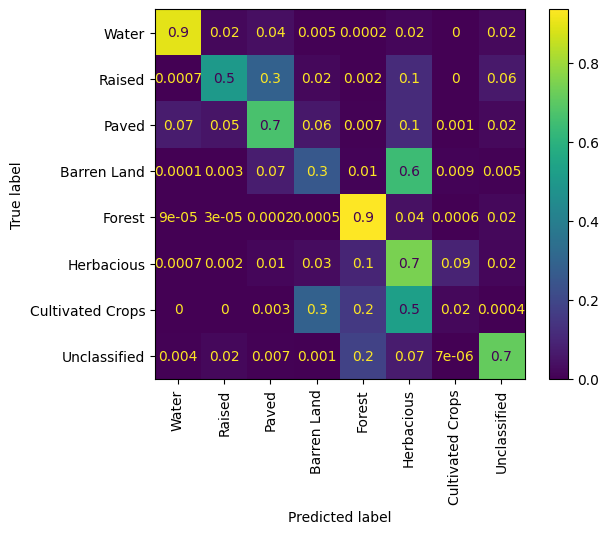

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(ys, y_hats, normalize='true', labels=range(0,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=land_cover_labels)
disp.plot(xticks_rotation='vertical', values_format='.1g')
plt.show()

### Visual analysis

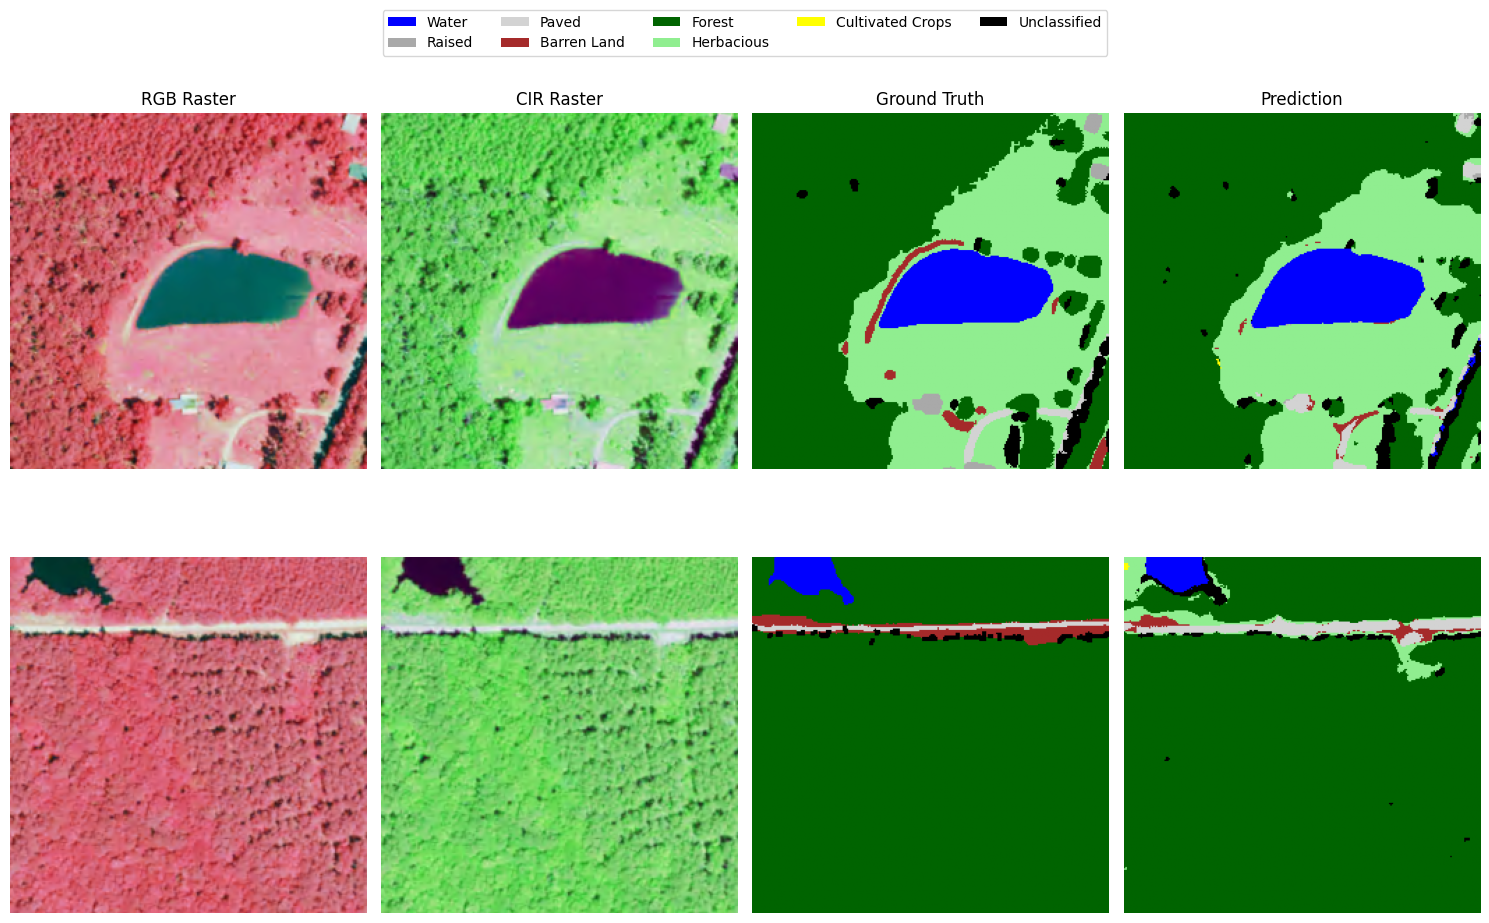

In [26]:
# create subplots for each raster, ground truth, and prediction

fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0][0].set_title('RGB Raster')
ax[0][1].set_title('CIR Raster')
ax[0][2].set_title('Ground Truth')
ax[0][3].set_title('Prediction')


for i in range(2):
    # Use sample from final batch of test loader
    raster = X[i].cpu().numpy() # convert to numpy array
    ground_truth = y[i].cpu().numpy()
    pred = y_hat[i].cpu().numpy()

    rgb_raster = raster[:3] # get RGB channels
    cir_raster = raster[[2, 0, 1], :, :] # get CIR channels

    # Transpose to (H, W, C) for matplotlib
    rgb_raster = rgb_raster.transpose(1, 2, 0)
    cir_raster = cir_raster.transpose(1, 2, 0)

    # Squeeze to remove extra dimension if present
    ground_truth = ground_truth.squeeze()
    pred = pred.squeeze()

    # Plot each image
    ax[i][0].imshow(rgb_raster)
    ax[i][1].imshow(cir_raster)
    ax[i][2].imshow(ground_truth, cmap=land_cover_cmap, vmin=0, vmax=8)
    ax[i][3].imshow(pred, cmap=land_cover_cmap, vmin=0, vmax=8)

    # remove axis ticks and labels
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
    ax[i][3].axis('off')

# Add land cover legend
fig.legend(handles=land_cover_legend, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=5)
fig.tight_layout()
plt.show()